<a href="https://colab.research.google.com/github/rodrigossilveira/DS_projects/blob/main/A2C_robot_energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install box2d-py
import gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 5.0 MB/s 


In [ ]:
!pip install roboticstoolbox-python['VPython']
!pip install -U numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.7 MB 5.2 MB/s 
     |████████████████████████████████| 1.5 MB 51.6 MB/s 
     |████████████████████████████████| 13.5 MB 28.0 MB/s 
     |████████████████████████████████| 178 kB 73.0 MB/s 
     |████████████████████████████████| 112.2 MB 94 kB/s 
     |████████████████████████████████| 26.9 MB 1.4 MB/s 
     |████████████████████████████████| 3.7 MB 33.1 MB/s 
     |████████████████████████████████| 112 kB 66.2 MB/s 
     |████████████████████████████████| 396 kB 63.4 MB/s 
     |████████████████████████████████| 4.0 MB 52.2 MB/s 
     |████████████████████████████████| 74 kB 4.9 MB/s 
     |████████████████████████████████| 1.1 MB 55.7 MB/s 
     |████████████████████████████████| 342 kB 72.5 MB/s 
     |████████████████████████████████| 561 kB 63.6 MB/s 
     |████████████████████████████████| 80 kB 12.0 MB/s 
     |████████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importing 
from roboticstoolbox import DHRobot, RevoluteDH, ERobot, ELink, ETS
import roboticstoolbox as rtb
from math import pi, sin, cos
import numpy as np
np.set_printoptions(linewidth=100, suppress=True)

#Defining characteristics of the links
m1,l1,lc1 = 1,1,0.5
m2,l2,c2 = 1,1,0.5

#Defining characteristics of link 2
m2,l2,lc2 = 1,1,0.5

# joint configurations

"""
q1 = [0, 0]        # o-o- arm horizontal
q2 = [0, pi/2]    # o-o| upper arm horizontal, lower arm vertical
q3 = [pi/2, 0]    # o|o| arm vertical
q4 = [pi/2, -pi/2] # o|o- upper arm upward, lower arm horizontal
qq = [q1, q2, q3, q4]
"""
z = [0, 0]

# global parameters
g = 9.81

L1 = RevoluteDH(a=l1, m=m1, r=[-lc1, 0, 0])
L2 = RevoluteDH(a=l2, m=m2, r=[-lc2, 0, 0])
robot = DHRobot([L1, L2], gravity=[0, g, 0])

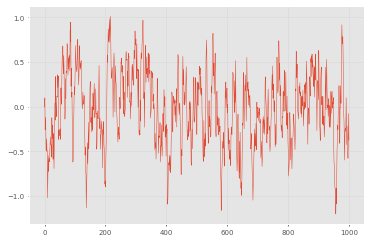

In [ ]:
import numpy as np
import torch
import shutil
import torch.autograd as Variable


def soft_update(target, source, tau):
	"""
	Copies the parameters from source network (x) to target network (y) using the below update
	y = TAU*x + (1 - TAU)*y
	:param target: Target network (PyTorch)
	:param source: Source network (PyTorch)
	:return:
	"""
	for target_param, param in zip(target.parameters(), source.parameters()):
		target_param.data.copy_(
			target_param.data * (1.0 - tau) + param.data * tau
		)


def hard_update(target, source):
	"""
	Copies the parameters from source network to target network
	:param target: Target network (PyTorch)
	:param source: Source network (PyTorch)
	:return:
	"""
	for target_param, param in zip(target.parameters(), source.parameters()):
			target_param.data.copy_(param.data)


def save_training_checkpoint(state, is_best, episode_count):
	"""
	Saves the models, with all training parameters intact
	:param state:
	:param is_best:
	:param filename:
	:return:
	"""
	filename = str(episode_count) + 'checkpoint.path.rar'
	torch.save(state, filename)
	if is_best:
		shutil.copyfile(filename, 'model_best.pth.tar')


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:

	def __init__(self, action_dim, mu = 0, theta = 0.15, sigma = 0.2):
		self.action_dim = action_dim
		self.mu = mu
		self.theta = theta
		self.sigma = sigma
		self.X = np.ones(self.action_dim) * self.mu

	def reset(self):
		self.X = np.ones(self.action_dim) * self.mu

	def sample(self):
		dx = self.theta * (self.mu - self.X)
		dx = dx + self.sigma * np.random.randn(len(self.X))
		self.X = self.X + dx
		return self.X


# use this to plot Ornstein Uhlenbeck random motion
if __name__ == '__main__':
	ou = OrnsteinUhlenbeckActionNoise(1)
	states = []
	for i in range(1000):
		states.append(ou.sample())
	import matplotlib.pyplot as plt

	plt.plot(states)
	plt.show()

In [ ]:
import numpy as np
import random
from collections import deque


class MemoryBuffer:

	def __init__(self, size):
		self.buffer = deque(maxlen=size)
		self.maxSize = size
		self.len = 0

	def sample(self, count):
		"""
		samples a random batch from the replay memory buffer
		:param count: batch size
		:return: batch (numpy array)
		"""
		batch = []
		count = min(count, self.len)
		batch = random.sample(self.buffer, count)

		s_arr = np.float32([arr[0] for arr in batch])
		a_arr = np.float32([arr[1] for arr in batch])
		r_arr = np.float32([arr[2] for arr in batch])
		s1_arr = np.float32([arr[3] for arr in batch])

		return s_arr, a_arr, r_arr, s1_arr

	def len(self):
		return self.len

	def add(self, s, a, r, s1):
		"""
		adds a particular transaction in the memory buffer
		:param s: current state
		:param a: action taken
		:param r: reward received
		:param s1: next state
		:return:
		"""
		transition = (s,a,r,s1)
		self.len += 1
		if self.len > self.maxSize:
			self.len = self.maxSize
		self.buffer.append(transition)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

EPS = 0.003

def fanin_init(size, fanin=None):
	fanin = fanin or size[0]
	v = 1. / np.sqrt(fanin)
	return torch.Tensor(size).uniform_(-v, v)

class Critic(nn.Module):

	def __init__(self, state_dim, action_dim):
		"""
		:param state_dim: Dimension of input state (int)
		:param action_dim: Dimension of input action (int)
		:return:
		"""
		super(Critic, self).__init__()

		self.state_dim = state_dim
		self.action_dim = action_dim

		self.fcs1 = nn.Linear(state_dim,256)
		self.fcs1.weight.data = fanin_init(self.fcs1.weight.data.size())
		self.fcs2 = nn.Linear(256,128)
		self.fcs2.weight.data = fanin_init(self.fcs2.weight.data.size())

		self.fca1 = nn.Linear(action_dim,128)
		self.fca1.weight.data = fanin_init(self.fca1.weight.data.size())

		self.fc2 = nn.Linear(256,128)
		self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())

		self.fc3 = nn.Linear(128,1)
		self.fc3.weight.data.uniform_(-EPS,EPS)

	def forward(self, state, action):
		"""
		returns Value function Q(s,a) obtained from critic network
		:param state: Input state (Torch Variable : [n,state_dim] )
		:param action: Input Action (Torch Variable : [n,action_dim] )
		:return: Value function : Q(S,a) (Torch Variable : [n,1] )
		"""
		s1 = F.relu(self.fcs1(state))
		s2 = F.relu(self.fcs2(s1))
		a1 = F.relu(self.fca1(action))
		x = torch.cat((s2,a1),dim=1)

		x = F.relu(self.fc2(x))
		x = self.fc3(x)

		return x


class Actor(nn.Module):

	def __init__(self, state_dim, action_dim, action_lim):
		"""
		:param state_dim: Dimension of input state (int)
		:param action_dim: Dimension of output action (int)
		:param action_lim: Used to limit action in [-action_lim,action_lim]
		:return:
		"""
		super(Actor, self).__init__()

		self.state_dim = state_dim
		self.action_dim = action_dim
		self.action_lim = action_lim

		self.fc1 = nn.Linear(state_dim,256)
		self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())

		self.fc2 = nn.Linear(256,128)
		self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())

		self.fc3 = nn.Linear(128,64)
		self.fc3.weight.data = fanin_init(self.fc3.weight.data.size())

		self.fc4 = nn.Linear(64,action_dim)
		self.fc4.weight.data.uniform_(-EPS,EPS)

	def forward(self, state):
		"""
		returns policy function Pi(s) obtained from actor network
		this function is a gaussian prob distribution for all actions
		with mean lying in (-1,1) and sigma lying in (0,1)
		The sampled action can , then later be rescaled
		:param state: Input state (Torch Variable : [n,state_dim] )
		:return: Output action (Torch Variable: [n,action_dim] )
		"""
		x = F.relu(self.fc1(state))
		x = F.relu(self.fc2(x))
		x = F.relu(self.fc3(x))
		action = F.tanh(self.fc4(x))

		action = action * self.action_lim

		return action


In [ ]:
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import math

#import utils
#import model

BATCH_SIZE = 128
LEARNING_RATE = 0.001
GAMMA = 0.99
TAU = 0.001


class Trainer:

	def __init__(self, state_dim, action_dim, action_lim, ram):
		"""
		:param state_dim: Dimensions of state (int)
		:param action_dim: Dimension of action (int)
		:param action_lim: Used to limit action in [-action_lim,action_lim]
		:param ram: replay memory buffer object
		:return:
		"""
		self.state_dim = state_dim
		self.action_dim = action_dim
		self.action_lim = action_lim
		self.ram = ram
		self.iter = 0
		self.noise = OrnsteinUhlenbeckActionNoise(self.action_dim)
  #self.noise = utils.OrnsteinUhlenbeckActionNoise(self.action_dim)

		self.actor = Actor(self.state_dim, self.action_dim, self.action_lim)
		self.target_actor = Actor(self.state_dim, self.action_dim, self.action_lim)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),LEARNING_RATE)

		self.critic = Critic(self.state_dim, self.action_dim)
		self.target_critic = Critic(self.state_dim, self.action_dim)
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),LEARNING_RATE)

		hard_update(self.target_actor, self.actor)
		hard_update(self.target_critic, self.critic)

	def get_exploitation_action(self, state):
		"""
		gets the action from target actor added with exploration noise
		:param state: state (Numpy array)
		:return: sampled action (Numpy array)
		"""
		new_state = Variable(torch.from_numpy(state))
		action = self.target_actor.forward(new_state).detach()
		return action.data.numpy()

	def get_exploration_action(self, state):
		"""
		gets the action from actor added with exploration noise
		:param state: state (Numpy array)
		:return: sampled action (Numpy array)
		"""
		new_state = Variable(torch.from_numpy(state))
		action = self.actor.forward(new_state).detach()
		new_action = action.data.numpy() + (self.noise.sample() * self.action_lim)
		return new_action

	def optimize(self):
		"""
		Samples a random batch from replay memory and performs optimization
		:return:
		"""
		s1,a1,r1,s2 = self.ram.sample(BATCH_SIZE)

		s1 = Variable(torch.from_numpy(s1))
		a1 = Variable(torch.from_numpy(a1))
		r1 = Variable(torch.from_numpy(r1))
		s2 = Variable(torch.from_numpy(s2))

		# ---------------------- optimize critic ----------------------
		# Use target actor exploitation policy here for loss evaluation
		a2 = self.target_actor.forward(s2).detach()
		next_val = torch.squeeze(self.target_critic.forward(s2, a2).detach())
		# y_exp = r + gamma*Q'( s2, pi'(s2))
		y_expected = r1 + GAMMA*next_val
		# y_pred = Q( s1, a1)
		y_predicted = torch.squeeze(self.critic.forward(s1, a1))
		# compute critic loss, and update the critic
		loss_critic = F.smooth_l1_loss(y_predicted, y_expected)
		self.critic_optimizer.zero_grad()
		loss_critic.backward()
		self.critic_optimizer.step()

		# ---------------------- optimize actor ----------------------
		pred_a1 = self.actor.forward(s1)
		loss_actor = -1*torch.sum(self.critic.forward(s1, pred_a1))
		self.actor_optimizer.zero_grad()
		loss_actor.backward()
		self.actor_optimizer.step()

		soft_update(self.target_actor, self.actor, TAU)
		soft_update(self.target_critic, self.critic, TAU)

		# if self.iter % 100 == 0:
		# 	print 'Iteration :- ', self.iter, ' Loss_actor :- ', loss_actor.data.numpy(),\
		# 		' Loss_critic :- ', loss_critic.data.numpy()
		# self.iter += 1

	def save_models(self, episode_count):
		"""
		saves the target actor and critic models
		:param episode_count: the count of episodes iterated
		:return:
		"""
		torch.save(self.target_actor.state_dict(), './Models/' + str(episode_count) + '_actor.pt')
		torch.save(self.target_critic.state_dict(), './Models/' + str(episode_count) + '_critic.pt')
		print('Models saved successfully')

	def load_models(self, episode):
		"""
		loads the target actor and critic models, and copies them onto actor and critic models
		:param episode: the count of episodes iterated (used to find the file name)
		:return:
		"""
		self.actor.load_state_dict(torch.load('./Models/' + str(episode) + '_actor.pt'))
		self.critic.load_state_dict(torch.load('./Models/' + str(episode) + '_critic.pt'))
		hard_update(self.target_actor, self.actor)
		hard_update(self.target_critic, self.critic)
		print('Models loaded succesfully')

In [ ]:
#observation = env.reset()
#Final point
q1f = pi/8
q2f = pi/8
t = 0.1 #Time step
q1_old,q2_old,qd1_old,qd2_old = 0,0,0,0 #Initializing angular speeds and accelerations as zero

observation = np.zeros(12)
print(observation)
#define starting enviroment
def reset():
  global q1,q2,qd1,qd2,qdd1,qdd2,dif_q1,dif_q2,dif_qd1,dif_qd2, tau1, tau, q1_old,q2_old,qd1_old,qd2_old
  q1,q2,qd1,qd2,qdd1,qdd2,dif_q1,dif_q2,dif_qd1,dif_qd2, tau1, tau2 = 0,0,0,0,0,0,q1f,q2f,0,0,0,0
  q1_old,q2_old,qd1_old,qd2_old = 0,0,0,0
  observation = q1,q2,qd1,qd2,qdd1,qdd2,dif_q1,dif_q2,dif_qd1,dif_qd2, tau1, tau2

#define action function
def take_action(a):
  global q1_old,q2_old,qd1_old,qd2_old, q1f, q2f
  q1,q2 = a[0] + q1_old +0.01 , a[1] + q2_old +0.01

#Checking limits of the links
  if abs(q1) > 1.6 or abs(q2) > 1.6:
    q1,q2 = q1_old, q2_old
    is_lim = -5
    
  else:
    is_lim = 0

  #Calculating speed and acceleration
  qd1 = (q1 - q1_old)/t
  qd2 = (q2 - q2_old)/t 
  qdd1 = (qd1 - qd1_old)/t 
  qdd2 = (qd2 - qd2_old)/t  

  #Calculating ditances to endpoint
  dif_q1 = q1f - q1
  dif_q2 = q2f - q2
  dif_qd1 = 0 - qd1
  dif_qd2 = 0 - qd2

  #Saving old speed and acceleration values
  q1_old, q2_old, qd1_old, qd2_old = q1,q2,qd1,qd2
  tau = robot.rne([q1,q2],[qd1,qd2],[qdd1,qdd2])
  energy = abs(tau*[a[0]+0.01,a[1]+0.01])
  inner_reward = -0.8*(energy[0] + energy[1]) -4*(abs(dif_q1) + abs(dif_q2)) + is_lim

    #Check if reached final point
  if (q1 <= q1f+ 0.07 and q1>= q1f - 0.07) and (q2<=q2f +0.07 and q2>= q2f - 0.07):
    done_status = True
    inner_reward += 150
  else:
    done_status = False
 
  
  arg = [q1,q2,qd1,qd2,qdd1,qdd2,dif_q1,dif_q2,dif_qd1,dif_qd2,tau[0],tau[1]]
  return arg,inner_reward,done_status,0

print(take_action([q1f,q2f]))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
([0.40269908169872415, 0.40269908169872415, 4.026990816987241, 4.026990816987241, 40.26990816987241, 40.26990816987241, -0.010000000000000009, -0.010000000000000009, -4.026990816987241, -4.026990816987241, 99.5759779442172, 38.438618925938606], 105.45731886349492, True, 0)


In [ ]:
reset()
print(take_action([q1f +0.02,q2f+0.02]))


([0.8553981633974483, 3.211592653589793, 8.553981633974482, 32.11592653589793, 85.53981633974482, 321.15926535897927, -0.07000000000000006, -0.06999999999999984, -8.553981633974482, -32.11592653589793, 11.666746964620948, 59.40116437577967], -145.91730325646517, True, 0)


In [ ]:
q1f+ 0.01, q1f - 0.1

(0.7953981633974483, 0.6853981633974483)

In [ ]:
from __future__ import division
import gym
import numpy as np
import torch
from torch.autograd import Variable
import os
import psutil
import gc

saved_data = [['Joint 1 angle', 'Joint 2 angle', 'Joint 1 speed', 'Joint 2 speed',
              'Joint 1 acceleration, Joint 2 acceleration', 'Dif to target 1',
              'Dif to target 2', 'Dif to "a" target 1', 'Dif to "a" target 2',
              'Jerk on joint 1', 'Jerk on joint 2', 'Reward']]
            
#import train
#import buffer

#env = gym.make('BipedalWalker-v3') - modified
# env = gym.make('Pendulum-v0')

MAX_EPISODES = 300
MAX_STEPS = 1500
MAX_BUFFER = 1000000
MAX_TOTAL_REWARD = 95

#################################################################################################
#Alter here
S_DIM = 12
A_DIM = 2
A_MAX = 0.02
#################################################################################################


print(' State Dimensions :- ', S_DIM)
print(' Action Dimensions :- ', A_DIM)
print(' Action Max :- ', A_MAX)

ram = MemoryBuffer(MAX_BUFFER)
#ram = buffer.MemoryBuffer(MAX_BUFFER)
trainer = Trainer(S_DIM, A_DIM, A_MAX, ram)
#trainer = train.Trainer(S_DIM, A_DIM, A_MAX, ram)

for _ep in range(MAX_EPISODES):

	#observation = env.reset() - modificado
	reset()
	print('EPISODE :- ', _ep)
	cumulative_reward = 0
	for r in range(MAX_STEPS):
		#env.render()
		state = np.float32(observation)

		#action = trainer.get_exploration_action(state)
		if np.random.rand(1) > 0.01:
		# 	# validate every 5th episode
			action = trainer.get_exploitation_action(state)
		else:
		# 	# get action based on observation, use exploration policy here
			action = trainer.get_exploration_action(state)
################################################################

		#new_observation, reward, done, info = env.step(action) - modified
		new_observation, reward, done, info = take_action(action)

		# # dont update if this is validation
		# if _ep%50 == 0 or _ep>450:
		# 	continue
		cumulative_reward += reward

		if done:
			new_state = None
		else:
			new_state = np.float32(new_observation)
			# push this exp in ram
			ram.add(state, action, reward, new_state)

		observation = new_observation

		# perform optimization
		trainer.optimize()
		if done:
			break
	saved_data.append(['Episode' + str(_ep), r,state,reward, cumulative_reward])
	# check memory consumption and clear memory
	gc.collect()
	# process = psutil.Process(os.getpid())
	# print(process.memory_info().rss)

	if _ep%100 == 0:
		trainer.save_models(_ep)
		#saved_data.append(df)

print('Completed episodes')

 State Dimensions :-  12
 Action Dimensions :-  2
 Action Max :-  0.02
EPISODE :-  0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Models saved successfully
EPISODE :-  1
EPISODE :-  2
EPISODE :-  3
EPISODE :-  4
EPISODE :-  5
EPISODE :-  6
EPISODE :-  7
EPISODE :-  8
EPISODE :-  9
EPISODE :-  10
EPISODE :-  11
EPISODE :-  12
EPISODE :-  13
EPISODE :-  14
EPISODE :-  15
EPISODE :-  16
EPISODE :-  17
EPISODE :-  18
EPISODE :-  19
EPISODE :-  20
EPISODE :-  21
EPISODE :-  22
EPISODE :-  23
EPISODE :-  24
EPISODE :-  25
EPISODE :-  26
EPISODE :-  27
EPISODE :-  28
EPISODE :-  29
EPISODE :-  30
EPISODE :-  31
EPISODE :-  32
EPISODE :-  33
EPISODE :-  34
EPISODE :-  35
EPISODE :-  36
EPISODE :-  37
EPISODE :-  38
EPISODE :-  39
EPISODE :-  40
EPISODE :-  41
EPISODE :-  42
EPISODE :-  43
EPISODE :-  44
EPISODE :-  45
EPISODE :-  46
EPISODE :-  47
EPISODE :-  48
EPISODE :-  49
EPISODE :-  50
EPISODE :-  51
EPISODE :-  52
EPISODE :-  53
EPISODE :-  54
EPISODE :-  55
EPISODE :-  56
EPISODE :-  57
EPISODE :-  58
EPISODE :-  59
EPISODE :-  60
EPISODE :-  61
EPISODE :-  62
EPISODE :-  63
EPISODE :-  64
EPISODE :-  65
EPISODE 

KeyboardInterrupt: ignored

In [ ]:
 saved_data[1]

['Episode0',
 959,
 array([  0.70857346,   1.1005895 ,   0.09987263,   0.09983124,  -0.00007842,  -0.00010058,
          0.07682472,  -0.05339194,  -0.09987263,  -0.09983124, -10.028351  ,   1.1625313 ],
       dtype=float32),
 149.60923835297737,
 -10763.507865962014]

<function matplotlib.pyplot.show>

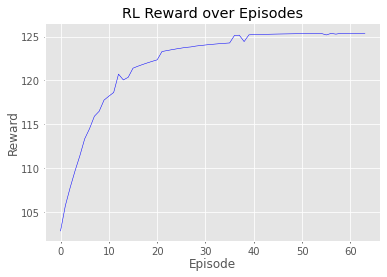

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
reward_1 = [el[4] for el in saved_data[10:]]
x=range(len(reward_1))
plt.plot(x,reward_1,c='blue' )
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('RL Reward over Episodes')
#plot.yticks(np.arange(0,300,50))
plt.show

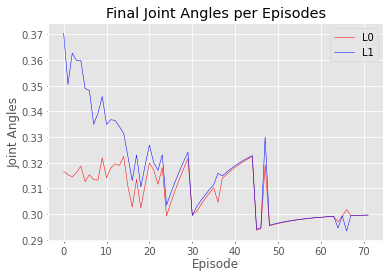

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
x = range(len(saved_data)-2)
q0 = [el[2][0] for el in saved_data[1:-1]]
q1 = [el[2][1] for el in saved_data[1:-1]]
plt.plot(x,q0,c='red',label = 'L0')
plt.plot(x,q1,c='blue',label='L1')
plt.title('Final Joint Angles per Episodes')
plt.ylabel('Joint Angles')
plt.xlabel('Episode')
plt.legend()
plt.show()

<function matplotlib.pyplot.show>

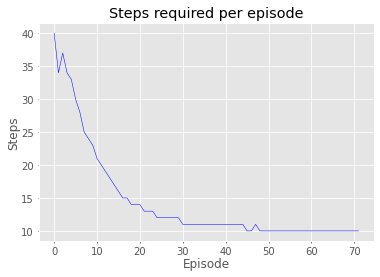

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
steps_1 = [el[1] for el in saved_data[1:-1]]
x=range(len(steps_1))
plt.plot(x,steps_1,c='blue' )
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps required per episode')
#plot.yticks(np.arange(0,300,50))
plt.show

In [ ]:
import pandas as pd
df = pd.DataFrame(ram.buffer)
df.head(-5)

,0,1,2,3
0,"[1.59, -0.53, 0.0, 0.0, 0.0, 0.0, -1.1973009, ...","[-0.0021586113, -0.00079402357]",-3.209939,"[0.007841389, 0.0092059765, 0.07841389, 0.0920..."
1,"[0.007841389, 0.0092059765, 0.07841389, 0.0920...","[-0.002131098, -0.00077277614]",-3.164615,"[0.01571029, 0.0184332, 0.078689024, 0.0922722..."
2,"[0.01571029, 0.0184332, 0.078689024, 0.0922722...","[-0.0021212297, -0.0007740895]",-3.096335,"[0.023589062, 0.02765911, 0.07878771, 0.092259..."
3,"[0.023589062, 0.02765911, 0.07878771, 0.092259...","[-0.0021207572, -0.0007736697]",-3.027852,"[0.031468302, 0.03688544, 0.07879243, 0.092263..."
4,"[0.031468302, 0.03688544, 0.07879243, 0.092263...","[-0.0021201575, -0.00077311334]",-2.959323,"[0.039348148, 0.04611233, 0.07879843, 0.092268..."
...,...,...,...,...
1038,"[0.3295659, 0.32957578, 0.29976562, 0.29976568...","[0.019973379, 0.019973442]",-3.183974,"[0.029973378, 0.029973442, 0.2997338, 0.299734..."
1039,"[0.029973378, 0.029973442, 0.2997338, 0.299734...","[0.019768508, 0.019777881]",-3.247599,"[0.05974189, 0.059751324, 0.2976851, 0.2977788..."
1040,"[0.05974189, 0.059751324, 0.2976851, 0.2977788...","[0.019988308, 0.01998817]",-3.004863,"[0.089730196, 0.089739494, 0.29988307, 0.29988..."
1041,"[0.089730196, 0.089739494, 0.29988307, 0.29988...","[0.01998754, 0.019987408]",-2.763194,"[0.11971773, 0.119726904, 0.2998754, 0.2998740..."


In [ ]:
ram.buffer[0]

(array([ 1.59      , -0.53      ,  0.        ,  0.        ,  0.        ,  0.        , -1.1973009 ,
         0.92269903,  0.        ,  0.        , -2.1153533 , -2.3979175 ], dtype=float32),
 array([-0.00215861, -0.00079402], dtype=float32),
 -3.2099392379104685,
 array([  0.00784139,   0.00920598,   0.07841389,   0.09205976,   0.78413886,   0.9205977 ,
          0.38485768,   0.3834931 ,  -0.07841389,  -0.09205976, -16.968197  ,  -4.086022  ],
       dtype=float32))

In [ ]:
j_a = [el[1] + 0.01 for el in ram.buffer]
states_z = [el[0] for el in ram.buffer]
tau_links = [el[10:12] for el in states]
q1q2 = [el[0:2] for el in states]
tau_links[0],j_a[0],q1q2[0]

(array([-2.1153533, -2.3979175], dtype=float32),
 array([0.00784139, 0.00920598], dtype=float32),
 array([ 1.59, -0.53], dtype=float32))

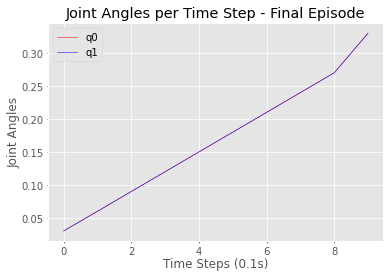

In [ ]:
#x = range(len(q1q2)-2)
rnt = q1q2[-19:-9]
x=range(len(rnt))
q0 = [el[0] for el in rnt]
q1 = [el[1] for el in rnt]
plt.plot(x,q0,c='red',label = 'q0')
plt.plot(x,q1,c='blue',label='q1')
plt.title('Joint Angles per Time Step - Final Episode')
plt.ylabel('Joint Angles')
plt.xlabel('Time Steps (0.1s)')
plt.legend()
plt.show()

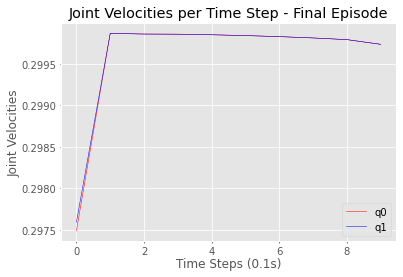

In [ ]:
rnt = j_a[-19:-9]
x=range(len(rnt))
q0 = [el[0]/0.1 for el in rnt]
q1 = [el[1]/0.1 for el in rnt]
plt.plot(x,q0,c='red',label = 'q0')
plt.plot(x,q1,c='blue',label='q1')
plt.title('Joint Velocities per Time Step - Final Episode')
plt.ylabel('Joint Velocities')
plt.xlabel('Time Steps (0.1s)')
plt.legend()
plt.show()

In [ ]:
}energy_z = [abs(tau_links[i][0]*j_a[i][0]+tau_links[i][1]*j_a[i][1]) for i in range(len(tau_links))]
energy_z[0:5],sum(energy_z)

SyntaxError: ignored

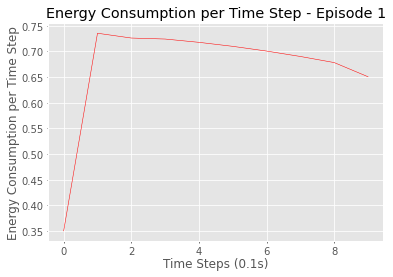

(None, 6.683620929718018)

In [ ]:
rnt = energy_z[-19:-9]
x=range(len(rnt))
q0 = [el for el in rnt]
#q1 = [el[1] for el in rnt]
plt.plot(x,q0,c='red',label = 'q0')
#plt.plot(x,q1,c='blue',label='q1')
plt.title('Energy Consumption per Time Step - Episode 1')
plt.ylabel('Energy Consumption per Time Step')
plt.xlabel('Time Steps (0.1s)')
#plt.legend()
plt.show(), sum(energy_z[-19:-9])

In [ ]:
all = [el[0] for el in ram.buffer]
all[0]

array([ 1.59      , -0.53      ,  0.        ,  0.        ,  0.        ,  0.        , -1.1973009 ,
        0.92269903,  0.        ,  0.        , -2.1153533 , -2.3979175 ], dtype=float32)